In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from scipy import fftpack
from scipy.signal import medfilt
import sys
import PIL;

In [3]:
root = 'torres_paine_pan.mp4'
cam = cv.VideoCapture(root)

In [4]:
currentframe = 0
vid = cv.VideoCapture(root)
spthreshold=0.999
properties = {'width': int(vid.get(cv.CAP_PROP_FRAME_WIDTH)),
                           'height': int(vid.get(cv.CAP_PROP_FRAME_HEIGHT)),
                           'fps': vid.get(cv.CAP_PROP_FPS)}

y = np.linspace(0, properties['height'], num=properties['height'])
x = np.linspace(0, properties['width'], properties['width'])
X, Y = np.meshgrid(x, y)
noise_angle = 2.0*np.pi*(20*Y + 2*X)
ret,frame = cam.read()
current_original_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
noisy_frame = current_original_frame.copy().astype(np.float32)/255.        
periodic_noise = 0.5 + 0.5*np.cos(noise_angle  - currentframe *0.1)
periodic_noise = periodic_noise.reshape(noisy_frame.shape)
noisy_frame += periodic_noise
noisy_frame /= np.amax(np.abs(noisy_frame))

spprob = np.random.rand(properties['height'], properties['width'])
smask = spprob > spthreshold
pmask = spprob < 1. - spthreshold
noisy_frame[smask] = 1.
noisy_frame[pmask] = 0.
noisy_frame=255*noisy_frame

#Guardamos unas imagenes de muestra
name = 'frame'+str(currentframe)+'.jpg'
cv.imwrite(name,noisy_frame)
name = 'frame'+str(currentframe+1)+'.jpg'
cv.imwrite(name,frame);

<IPython.core.display.Javascript object>


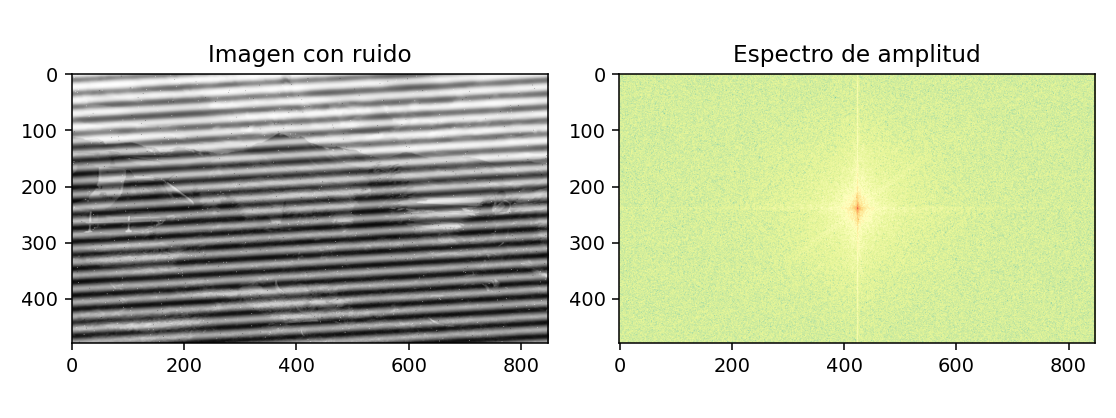

In [5]:
#Imagen con ruido y su espectro de amplitud
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
ax[0].imshow(noisy_frame, cmap=plt.cm.Greys_r) 
ax[0].set_title("Imagen con ruido")
S = fftpack.fft2(noisy_frame)
ax[1].imshow(fftpack.fftshift(np.log(1+np.abs(S))), cmap=plt.cm.Spectral_r)
ax[1].set_title("Espectro de amplitud");

In [6]:
#Mascara para quitar el ruido Periodico
def create_mask(dims, frequency, size=3):
    freq_int = int(frequency*dims[0])
    mask = np.ones(shape=(dims[0], dims[1]))
    mask[dims[0]//2-size-freq_int+1:dims[0]//2+size-freq_int, dims[1]//2-size:dims[1]//2+size] = 0 
    mask[dims[0]//2-size+freq_int+1:dims[0]//2+size+freq_int, dims[1]//2-size:dims[1]//2+size] = 0
    return mask


In [7]:
#Aplicacion de la mask
S_img= fftpack.fftshift(fftpack.fft2(noisy_frame))
espectro_filtrado = S_img*create_mask(S_img.shape, 0.042)
img_reconstructed = np.real(fftpack.ifft2(fftpack.ifftshift(espectro_filtrado)))

<IPython.core.display.Javascript object>


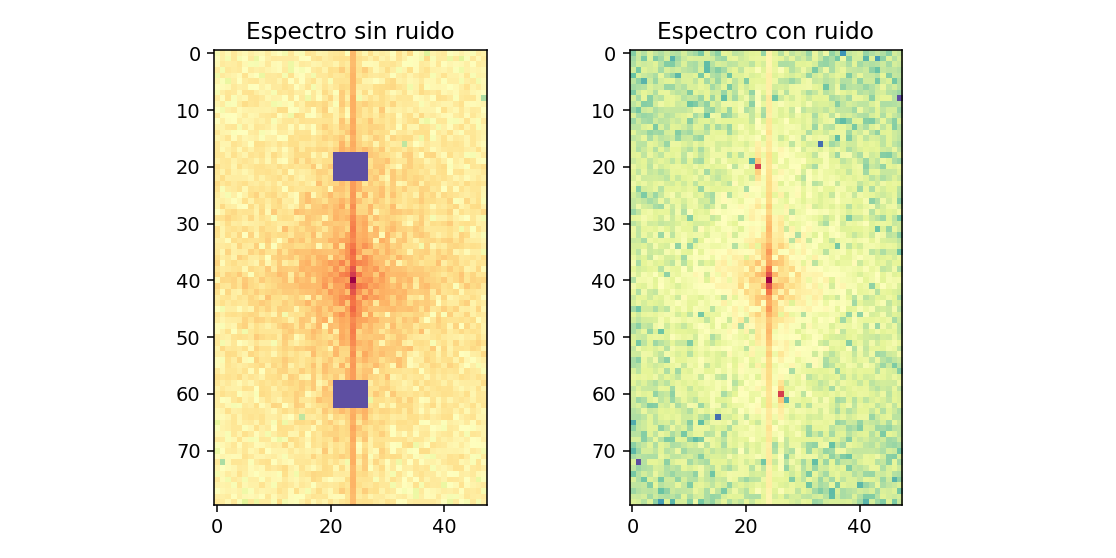

In [8]:
#Espectro de amplitud aplicada la mask
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax[0].imshow(np.log(1+np.abs(espectro_filtrado))[200:-200, 400:-400], cmap=plt.cm.Spectral_r)
ax[0].set_title("Espectro sin ruido")
ax[1].imshow(fftpack.fftshift(np.log(1+np.abs(S)))[200:-200, 400:-400], cmap=plt.cm.Spectral_r)
ax[1].set_title("Espectro con ruido");

<IPython.core.display.Javascript object>


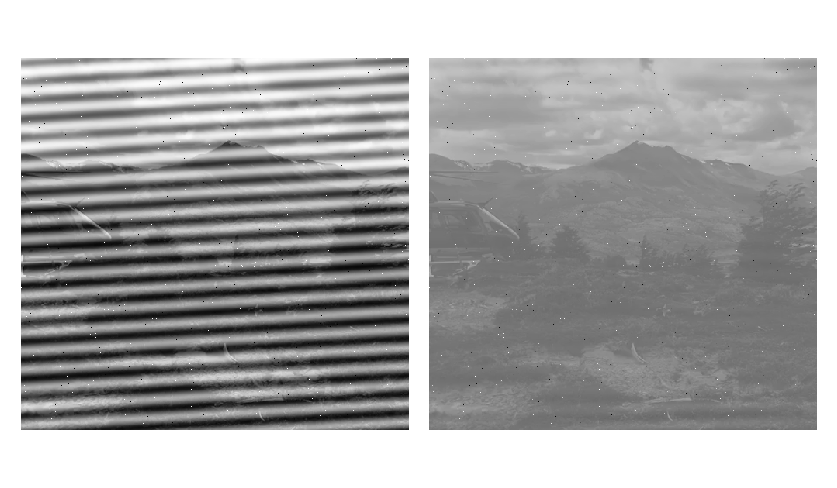

In [9]:
#Comparacion de la imagen sin ruido
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True)
ax[0].matshow(noisy_frame[:, 100:600], cmap=plt.cm.Greys_r);
ax[0].axis('off')
ax[1].matshow(img_reconstructed[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].axis('off')

#Guardamos una imagen de muestra
name = 'frame'+str(currentframe+2)+'.jpg'
cv.imwrite(name,img_reconstructed);

In [10]:
#Filtro sal y pimienta 
img_filtered = medfilt(img_reconstructed,5)

<IPython.core.display.Javascript object>


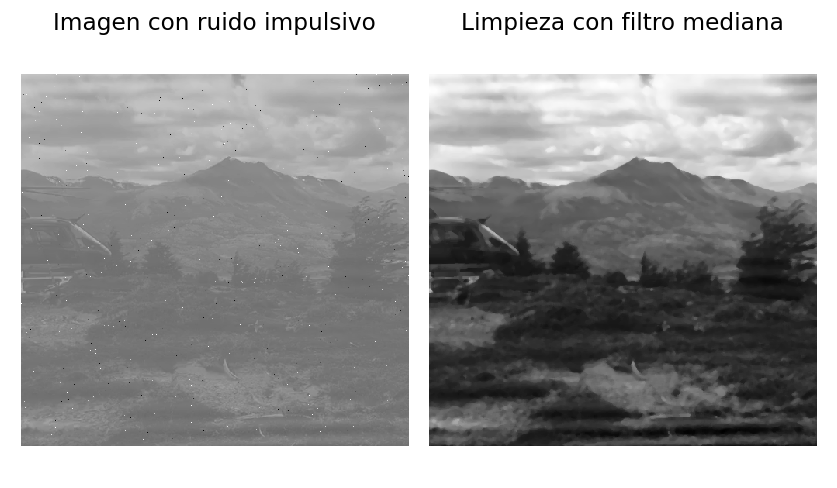

In [11]:
#Comparacion con y sin filtro
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(img_reconstructed[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(img_filtered[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Limpieza con filtro mediana')
ax[1].axis('off');

In [12]:
#Separacion en bloques de 8x8 
imsize = img_filtered.shape
colores_matrix = np.zeros(shape=imsize)

#Se recorre la imagen en bloques de 8x8
for i in range(0, imsize[0], 8):
    for j in range(0, imsize[1], 8):
        colores_matrix[i:(i+8),j:(j+8)] = img_filtered[i:(i+8),j:(j+8)]

In [13]:
#Convierte el arreglo de floats a un arreglo de enteros multiplos de m
colores_matrix = colores_matrix.astype(int)
m = 7
new_colores = np.array([x-x%m for x in colores_matrix])

In [14]:
#convertimo el arreglo en una lista
colores_list= np.concatenate(new_colores.tolist())

In [19]:

#Se comprimen en una lista de largo flexible
def compress(l):
    acum = 0
    vAcum = []
    lcomp = []
    for i in range(len(l)):
        if (i + 1) < len(l) and l[i] == l[i+1]:
            acum += 1
            vAcum = [acum, l[i]]
            continue
        if vAcum:
            vAcum[0] += 1
            lcomp.append(vAcum[0])
            lcomp.append(vAcum[1])
            vAcum = []
            acum = 0
        else:
            lcomp.append(1)
            lcomp.append(l[i])
    return lcomp

colores_compressed = compress(colores_list)
#tamaño en mb

fps=12
print("Tamaño de la imagen comprimida: ", (sys.getsizeof(colores_compressed)*8)*0.000001,"Mb")
print("Ancho de banda: ",fps*(sys.getsizeof(colores_compressed)*8)*0.000001,"Mbps")

Tamaño de la imagen comprimida:  5.0625919999999995 Mb
Ancho de banda:  60.751104 Mbps


In [20]:

############################################Esto es nuevo###################################
#Dendograma
strcolores_compressed = colores_compressed

from collections import Counter
p = np.linspace(0.01, 0.99, num=100)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)

import heapq

# Construir dendograma con las probabilidades ordenadas
dendograma = [[frequencia/len(strcolores_compressed), [simbolo, ""]] for simbolo, frequencia in Counter(strcolores_compressed).items()]
heapq.heapify(dendograma)

def take_second(elem):
    return len(elem[1])

# Crear el código
while len(dendograma) > 1:
    lo = heapq.heappop(dendograma)
    hi = heapq.heappop(dendograma)
    for codigo in lo[1:]:
        codigo[1] = '0' + codigo[1]
    for codigo in hi[1:]:
        codigo[1] = '1' + codigo[1]
    heapq.heappush(dendograma, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Convertir código a diccionario
dendograma=sorted(heapq.heappop(dendograma)[1:],key=take_second)
#dendograma = sorted(heapq.heappop(dendograma)[1:])

dendograma = {simbolo : codigo for simbolo, codigo in dendograma} 
#display(dendograma);

strcolores_compressed_codificado = ""
for letra in strcolores_compressed:
    strcolores_compressed_codificado += dendograma[letra]

print("Tamaño de la imagen sin comprimir: ", (sys.getsizeof(colores_matrix)*8)*0.000001,"Mb")
print("Tamaño de la imagen comprimida: ", len(strcolores_compressed_codificado)*0.000001,"Mb")
print("Ancho de banda: ",fps*len(strcolores_compressed_codificado)*0.000001,"Mbps")


Tamaño de la imagen sin comprimir:  26.05152 Mb
Tamaño de la imagen comprimida:  0.380781 Mb
Ancho de banda:  4.5693719999999995 Mbps


In [21]:
import json
message=[str(dendograma),strcolores_compressed_codificado]
message_json = json.dumps(message)

###decode
message_rec = json.loads(message_json)
dendograma_rec=eval(message_rec[0])
strcolores_compressed_codificado_rec=message_rec[1]
colores_compressed_rec=[]
lista_valores = list(dendograma.values())
lista_llaves = list(dendograma.keys())
i=0
cont=len(strcolores_compressed_codificado_rec)
while(len(strcolores_compressed_codificado_rec)!=0):
    if(lista_valores[i]==strcolores_compressed_codificado_rec[:len(lista_valores[i])]):
        colores_compressed_rec.append(lista_llaves[i])
        strcolores_compressed_codificado_rec=strcolores_compressed_codificado_rec[len(lista_valores[i]):]
        i=0
    else:
        i+=1

In [22]:
seq = colores_compressed_rec
lista_decompressed = []
for i in range(0,len(seq),2):
    for j in range(seq[i]):
        lista_decompressed.append(seq[i+1])
lista = [lista_decompressed[i:i+64] for i in range(0,len(lista_decompressed),64)]
while (len(lista)%8 != 0):
    lista.append(lista[-1])
lista2=[]
for i in lista:
    lista2.append([i[j:j+8] for j in range(0,len(i),8)])
lista3 = np.asarray(lista2)
lista3 = lista3.reshape(480,848)

<IPython.core.display.Javascript object>


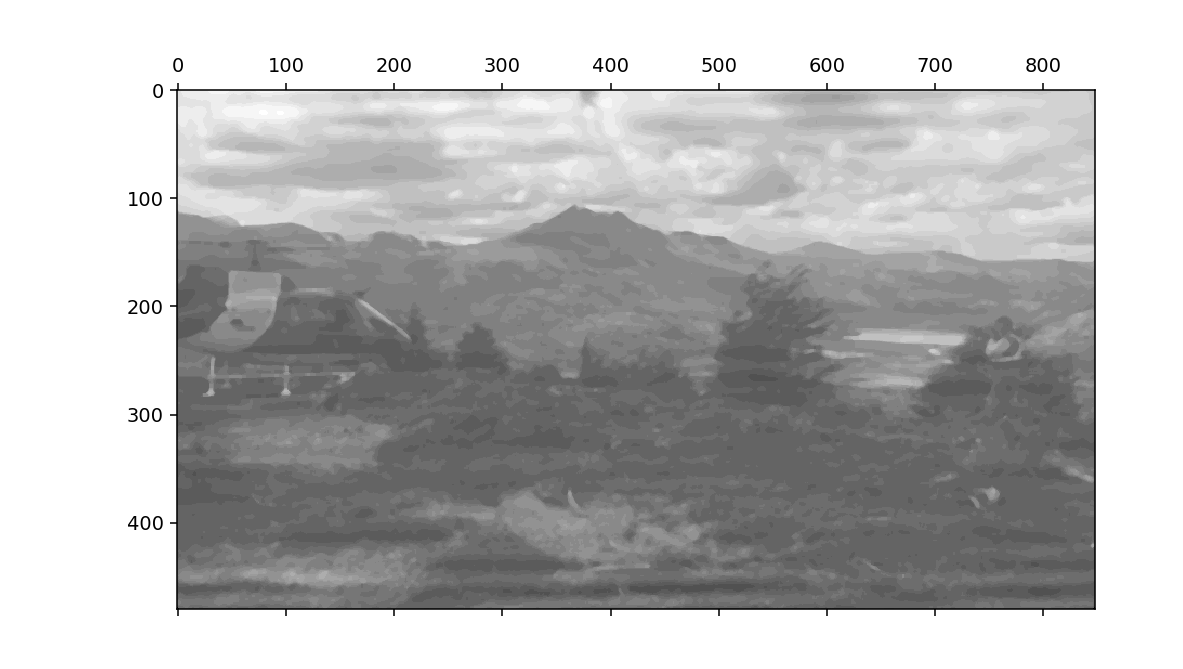

In [23]:
#Imprime frame decompressed 
plt.matshow(lista3 , cmap = "gray");

In [57]:
Error= float(abs(img_filtered-lista3)/lista3)*100))
np.concatenate(Error)
print(type(Error[1]))
for i in range(len(Error)):
    if type(Error[i])!=float:
        Error[i]=0
print(Error)

SyntaxError: unmatched ')' (<ipython-input-57-749b0776c900>, line 1)